In [ ]:
# !pip install imutils

In [ ]:
# !conda install -c conda-forge ipywidgets -y

#notes get semi circle tracking

#https://stackoverflow.com/questions/20698613/detect-semicircle-in-opencv

In [5]:
#https://pyimagesearch.com/2015/09/14/ball-tracking-with-opencv/

# import the necessary packages
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
import time
from matplotlib import pyplot as plt
from math import sqrt
import urllib.request
from datetime import datetime
import ipywidgets as widgets
import pandas as pd
from statistics import mean, variance, stdev
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-v", "--video", help="path to the (optional) video file");
ap.add_argument("-b", "--buffer", type=int, default=64, help="max buffer size");
#args = vars(ap.parse_args())
buffer = 64
# define the lower and upper boundaries of the "green"
# ball in the HSV color space, then initialize the
# list of tracked points
greenLower = (29, 86, 6)
greenUpper = (64, 255, 255)

#pts = deque(maxlen=args["buffer"])
pts = deque(maxlen = buffer)

# if a video path was not supplied, grab the reference
# to the webcam
# if not args.get("video", False):
#     vs = VideoStream(src=0).start()
# # otherwise, grab a reference to the video file
# else:
#     vs = cv2.VideoCapture(args["video"])

#vs = VideoStream(src="rtsp://advancedcameranode.local:8554/cam").start()

#vs = VideoStream(src="http://camerag11.local/html/min.php").start()
# allow the camera or video file to warm up
#time.sleep(2.0)
# from IPython.display import display
# take_pic = 0
# button = widgets.Button(description="Click Me!")
# output = widgets.Output()

# display(button, output)
# def on_button_clicked(b):
#     with output:
#         take_pic += 1
#         print("Button clicked.")
#         print(str(take_pic))

# button.on_click(on_button_clicked)


ToggleButton(value=False, description='capture image')

IntProgress(value=0, description='Buffer', max=50)

IntProgress(value=0, description='Captures', max=2)

Text(value='00', description='filename')

IntSlider(value=1, description='Increment', max=30, min=1)

ToggleButton(value=False, description='plot size')

Text(value='19-August-2022T19:36:26', description='folder')

Button(description='Create Folder', style=ButtonStyle())

FloatProgress(value=0.0, max=1.0)

ToggleButton(value=False, description='get dataframe')

ToggleButton(value=False, description='force capture')

ToggleButton(value=False, description='Stop')

Output()

Output()

<Task pending name='Task-28' coro=<f() running at /var/folders/5z/d1d_q74d1hd653s14vwq9v800000gn/T/ipykernel_99663/1179597541.py:215>>

hello
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str d

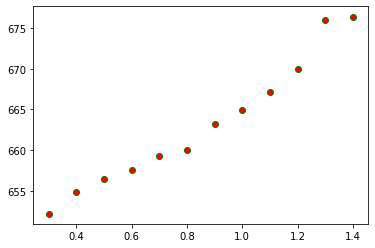

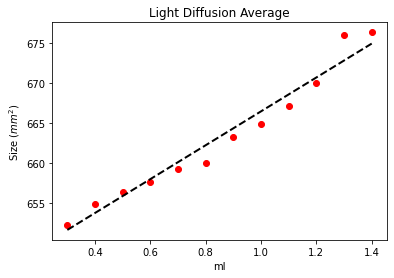

type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't

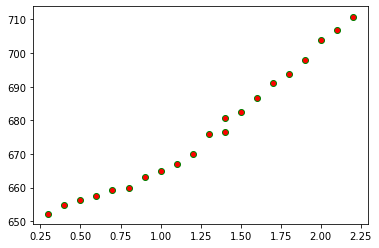

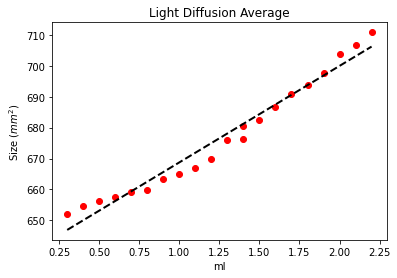

type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't

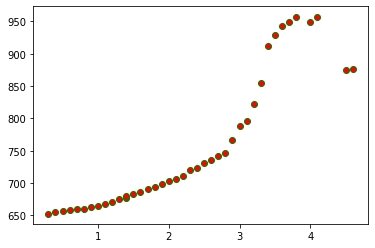

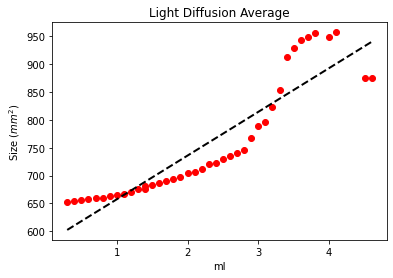

type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't define __round__ method
type str doesn't

In [27]:
%gui asyncio
import asyncio
from cgi import MiniFieldStorage
import ipywidgets as widgets
import os
import math
import csv
import numpy as np
import sys

from datetime import datetime

# Getting the current date and time
dt = datetime.now()
## todo:
# 1. save the contents of the precision buffers into a dataframe
# 2. get the plots to come out separately
# 3. Gather data 
image_dir = "/Users/pierre/Pictures/biology/Blob-Measuring/Level-Measurement-Experiment/stream-captures/"

BUFFER_SIZE = 50
PRECISION_BUFFER_SIZE = 2
circle_mode = False
hough_mode = False
stdev_threshold = 0.3
camera_name = "camerafluidleveldetect"
progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
buffer_progress = widgets.IntProgress(value=0, min=0, max=BUFFER_SIZE)
buffer_progress.description = "Buffer"
capture_progress = widgets.IntProgress(value=0, min=0, max=PRECISION_BUFFER_SIZE)
capture_progress.description = "Captures"
capture_dataframe = widgets.ToggleButton()
capture_dataframe.description = "get dataframe"
capture_datapoint = widgets.ToggleButton()
capture_datapoint.description = "capture image"
force_capture = widgets.ToggleButton()
force_capture.description = "force capture"
display(capture_datapoint)
display(buffer_progress)
display(capture_progress)
fluid_volume = widgets.Text()
fluid_volume.value = "00"
fluid_volume.description = "filename"
#an int slider widget that sets the value of fluid_volume.value
fluid_value_slider = widgets.IntSlider(value=1, min=1, max=30, step=1)
fluid_value_slider.description = "Increment"


img_folder = widgets.Text()
img_folder.description = "folder"
img_folder.value = dt.strftime("%d-%B-%YT%H:%M:%S")
plot = widgets.ToggleButton()
plot.description = "plot size"

output = widgets.Output()
output_plot = widgets.Output()
#a button to create a new folder
dir_button = widgets.Button(description="Create Folder")
#a button widget that creates a directory from the img_folder.value parameter
def create_folder(b):
    with output:
        if img_folder.value is not None:
            if not os.path.exists(image_dir+img_folder.value):
                os.makedirs(image_dir+img_folder.value)
                print("Folder Created")
            else:
                print("Folder already exists")
        else:
            print("Folder not created")

def trace_active_rectangle(image, width, height, offsetX, offsetY):
    centerX = int(image.shape[1] / 2)
    centerY = int(image.shape[0] / 2)
    # color is magenta
    color = (255, 0, 255)
    cv2.rectangle(image, (centerX + offsetX - int(width/2), centerY+offsetY-int(width/2)), (centerX + offsetX + int(width/2), centerY+offsetY + int(height/2)), color, 2)

    # w = 50
    # h = 5
    # xOffset = 50
    # yOffset = 50

    # cv2.circle(frame, (centerX + xOffset, centerY + yOffset), radius=0, color=(0, 0, 255), thickness=-1)

#low pass filter value from rolling buffer


def get_best_circle(image):
    #compute distance transform of image
    image = cv2.bitwise_not(cv2.Canny(image,100,200))
    # image = cv2.bitwise_not(cv2.Canny(image,10,20))
    cv2.imshow("window2", image)
    dist = cv2.distanceTransform(image, cv2.DIST_L2, 0)
    rows = image.shape[0]
    min_distance = rows / 8
    # min_distance = 1
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, min_distance , param1=50, param2=10, minRadius=40, maxRadius=70)      
    minInlierDist = 0

    max_radius = 0
    max_inlier_percent = 0
    max_arc_points = [[],[]]
    max_center = (-1,-1)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for c in circles[0, :]:
        counter = 0
        inlier = 0
        center = (c[0], c[1])
        radius = c[2]
        #maxInlierDist = radius/50.0
        maxInlierDist = 1.5
        inlier_arc = 0
        max_inlier_arc = 0
        last_point_inbounds = False

        arc_points = [[],[]]
        max_arc_points_current_circle = [[],[]]
        #save first arc incase it loops around
        first_arc = True
        first_arc_points = [[],[]]


        if maxInlierDist < minInlierDist: maxInlierDist = minInlierDist

        for i in np.arange(0, 2*np.pi, 0.1):
            counter += 1
            x = center[0] + radius * np.cos(i)
            y = center[1] + radius * np.sin(i)
            try:
                if dist.item(int(y), int(x)) < maxInlierDist:
                    if last_point_inbounds:
                        inlier_arc += 1
                    else:
                        inlier_arc = 1
                        last_point_inbounds = True

                    arc_points[0].append(int(x))
                    arc_points[1].append(int(y))

                    inlier += 1
                    # cv2.circle(image, (int(x), int(y)), 1, (0, 255, 0), -1)

                    #if last iteration, save arc
                    if counter == len(np.arange(0, 2*np.pi, 0.1)):
                        arc_points[0] = arc_points[0] + first_arc_points[0]
                        arc_points[1] = arc_points[1] + first_arc_points[1]

                        inlier_arc += len(first_arc_points[0])
                        if inlier_arc > max_inlier_arc:
                            max_inlier_arc = inlier_arc
                            max_arc_points_current_circle = arc_points.copy()
                else:
                    if first_arc:
                        first_arc_points = arc_points.copy()
                        # first_arc_points[0].append(arc_points[0].copy())
                        # first_arc_points[1].append(arc_points[1].copy())
                        first_arc = False

                    if inlier_arc > max_inlier_arc:
                        max_inlier_arc = inlier_arc
                        max_arc_points_current_circle = arc_points.copy()
                    
                    arc_points = [[],[]]
                    last_point_inbounds = False

                    # cv2.circle(image, (int(x), int(y)), 1, (255, 0, 0), -1)

            except(IndexError):
                pass
                # print("IndexError, circle bigger than image")

        if max_inlier_arc/counter > max_inlier_percent:
            max_inlier_percent = inlier/counter
            max_radius = int(radius)
            max_center = (int(center[0]), int(center[1]))
            max_arc_points = max_arc_points_current_circle.copy()

            # with output:
            #     # print(str(100.0*inlier/counter) + ' percent of a circle with radius ' + str(radius) + " detected")
    for i in range(len(max_arc_points[0])):
        cv2.circle(image, (max_arc_points[0][i], max_arc_points[1][i]), 2, (255, 0, 255), -1)
    # cv2.circle(image, max_center, int(max_radius), (255, 0, 255), 2)
    # (int(max_center[0]),int(max_center[1]))
    cv2.imshow("window2", image)
    return max_radius, max_center



dir_button.on_click(create_folder)

display(fluid_volume)
display(fluid_value_slider)
display(plot)
display(img_folder)
display(dir_button)
display(progress)
display(capture_dataframe)
#display(text_input)
#text.value= str(button.value)
display(force_capture)
stop_button = widgets.ToggleButton()
stop_button.description = "Stop"
display(stop_button)

display(output)
display(output_plot)

# a method that returns the mean but rejects outliers from the calculation
def mean_filter(data, threshold):
    data_mean = mean(data)
    data_std = stdev(data)
    data_filtered = [x for x in data if abs(x - data_mean) < threshold * data_std]
    return mean(data_filtered), stdev(data_filtered)

async def f():   
    i=0
    size = [[],[],[],[],[],[],[]]
    perimeter_buffer_list = []
    area_buffer_list = []

    perimeter_value_frame = []
    area_value_frame = []
    dataframe_count = 0
    dataframe_total = 100

    perimeter_frame_dict = {}
    area_frame_dict = {}
    area_buffer = []
    area_precision_buff = []
    perimeter_buffer = []
    perimeter_precision_buff = []
    buffer_size = BUFFER_SIZE
    buffer_fill = 0
    first = True

    for i in range(buffer_size):
        area_buffer.append(0)
        perimeter_buffer.append(0)

    stream = urllib.request.urlopen('http://' + camera_name +'.local/html/cam_pic.php')
    bytes = b''
    #os.chdir(image_dir)

    WINDOW_NAME = "Camera"
    cv2.namedWindow(WINDOW_NAME)
    cv2.namedWindow("window2")
    cv2.startWindowThread()
    print("hello")

    #transfer_function_coeffs = [-6.40190835e-05 , 1.00543104e-01 , -3.52312603e+01]
    transfer_function_coeffs = [  0.02130269, -11.15089045]


    while True:
        # grab the frame from the threaded video stream, resize it, and convert it to grayscale
        curr_dt = datetime.now()
        timestamp = int(round(curr_dt.timestamp()))
    #     print("Integer timestamp of current datetime: ",
    #       timestamp)
        bytes += stream.read(1024)
        a = bytes.find(b'\xff\xd8') #frame starting 
        b = bytes.find(b'\xff\xd9') #frame ending
        if a != -1 and b != -1:
            jpg = bytes[a:b+2]
            bytes = bytes[b+2:]
            frame = cv2.imdecode(np.frombuffer(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)


            centerX = frame.shape[1]/2
            centerY = frame.shape[0]/2
            w = 300
            h = 300
            x = int(centerX - w/2)
            y = int(centerY - h/2)
            #crop frame to focus only on middle section
            frame = frame[y:y+h, x:x+w]
            start_image = frame.copy()
            bytes = b''
            url = 'http://' + camera_name +'.local/html/cam_pic.php?' + str(timestamp)
            #print(url)
            stream = urllib.request.urlopen(url)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_blurred = cv2.medianBlur(gray,91)

            perimeter = "boof"

            rows = frame.shape[0]
            # minDist is parameter 5 in houghcircles() but does not work will minDist=val
            # param1 is sensitivity to edge detection, param2 is num points to detect circles
            xOffset = 15
            yOffset = -10
            centerX = int(frame.shape[1] / 2)
            centerY = int(frame.shape[0] / 2)
            w = 100
            h = 100
           

            if hough_mode:
                trace_active_rectangle(frame, w, h, xOffset, yOffset)
                #following 2 lines needed to avoid error when displaying

                gray_blurred = cv2.cvtColor(gray_blurred, cv2.COLOR_GRAY2BGR)
                mask = np.zeros(frame.shape[:2], dtype="uint8") 

                ret, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
                frame = thresh.copy()
                frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
                #trace_active_rectangle(frame, w, h, xOffset, yOffset)

                # w=100
                # h=100

                try:
                    radius, center = get_best_circle(thresh)
                    #         if center[0] < centerX + xOffset - int(w/2) or center[0] > centerX + xOffset + int(w/2) or center[1] < centerY + yOffset - int(h/2) or center[1] > centerY + yOffset + int(h/2):
                    #             continue
                    if radius != 0:
                        cv2.circle(frame, center, radius, (255, 0, 255), 3)
                        perimeter = float(radius)
                        perimeter_buffer.pop(0)
                        perimeter_buffer.append(perimeter)
                        buffer_fill += 1
                        area = 0 #placeholder
                        area_buffer.pop(0)
                        area_buffer.append(area)
                            
                except(Exception):
                    # print info about the exception
                    print(sys.exc_info())
                    print("Error: ", Exception)
                    #print the exception


            else: #contour mode
                if circle_mode:
                    gray_blurred = cv2.medianBlur(gray,21)
                    ret, thresh = cv2.threshold(gray_blurred, 150, 255, cv2.THRESH_BINARY_INV)
                else: #ellipse mode
                    gray_blurred = cv2.medianBlur(gray,21)
                    ret, thresh = cv2.threshold(gray_blurred, 60, 255, cv2.THRESH_BINARY)

                cnt = 0
                # frame = thresh
                # frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
                # trace_active_rectangle(frame, w, h, xOffset, yOffset)
                gray_blurred = cv2.cvtColor(gray_blurred, cv2.COLOR_GRAY2BGR)

                mask = np.zeros(frame.shape[:2], dtype="uint8") #define mask out here to avoid crashing when exception is thrown
                try:
                    contours,hierarchy = cv2.findContours(thresh, 1, cv2.CHAIN_APPROX_NONE)
                    # cv2.drawContours(frame, contours, -1, (0,255,0), 3)
                    threshold_area_min = 5000     #threshold area 
                    threshold_area_max = 20000
                    # contours, hierarchy = cv2.findContours(thresh,1,2)  
                    # cnt = contours[0]
                    found = False
                    for cntr in contours:  
                        area = cv2.contourArea(cntr) 
                        if  area > threshold_area_min and area < threshold_area_max: 
                            #removed circle mode check because tracking the center still helps us in ellipso mode

                            #get minimum enclosing circle
                           
                            #get maximum inscribed circle
                            inscribed_circle = False
                            if inscribed_circle:
                                cv2.drawContours(mask, [cntr], -1, 255, -1)
                                # cv2.distanceTransform(mask, dist, distanceType, maskSize)
                                dist = cv2.distanceTransform(mask, cv2.DIST_L2, 0)
                                NULL,max_val,NULL,max_indx=cv2.minMaxLoc(dist)

                                (x,y),radius = max_indx, max_val
                            # print(max_val,max_indx)
                            else:

                                mask = thresh
                                (x,y),radius = cv2.minEnclosingCircle(cntr)

                            # masked = cv2.bitwise_and(gray_blurred, image, mask=mask)
                            # draw the circle and centroid on the frame
                            center = (int(x),int(y))
                            if center[0] < centerX + xOffset - int(w/2) or center[0] > centerX + xOffset + int(w/2) or center[1] < centerY + yOffset - int(h/2) or center[1] > centerY + yOffset + int(h/2):
                                continue

                            radius = int(radius)

                            cv2.circle(frame,center,radius,(255,255,0),2)
                            cv2.circle(start_image,center,radius,(255,255,0),2)
                            #get perimeter of circle

                            #color = cyan
                            # cv2.circle(frame,center,radius,(0,255,0),2)
                            # cv2.circle(start_image,center,radius,(0,255,0),2)
                            cnt = cntr
                            area_buffer.pop(0)
                            area_buffer.append(area)
                            # perimeter_buffer.pop(0)
                            # perimeter_buffer.append(perimeter)
                            buffer_fill += 1

                            if circle_mode:
                                perimeter = 2*np.pi*radius
                                perimeter_buffer.pop(0)
                                perimeter_buffer.append(perimeter)

                            else:
                                ellipse = cv2.fitEllipse(cnt)
                                cv2.ellipse(frame,ellipse,(255,0,255),2)
                                (a,b) = ellipse[1]
                                perimeter = (2 * 3.14 * sqrt((a * a + b * b) / (2 * 1.0)))
                                perimeter_buffer.pop(0)
                                perimeter_buffer.append(perimeter)
                            
                            break
                        # cnt = contours[0]
                        # M = cv2.moments(cnt)


                    
                    # let circle = cv.minEnclosingCircle(cnt);
                    # let contoursColor = new cv.Scalar(255, 255, 255);
                    # let circleColor = new cv.Scalar(255, 0, 0);
                    # cv.drawContours(dst, contours, 0, contoursColor, 1, 8, hierarchy, 100);
                    # cv.circle(dst, circle.center, circle.radius, circleColor);




                except Exception as e:
                    print(e)

                    
            buffer_progress.value = min(buffer_fill, buffer_size)
            # Display measured values on frame
   
            font = cv2.FONT_HERSHEY_SIMPLEX
            #org = (50, 50)
            fontScale = 0.5
            color = (0, 136, 17)
            thickness = 1
            
            filtered_mean, filtered_stdev = mean_filter(perimeter_buffer, 1)
            try:
                display_frame = cv2.putText(frame, "per: " + str(round(perimeter,2)), (50,50), font, 
                                    fontScale, color, thickness, cv2.LINE_AA)
                # display_frame = cv2.putText(display_frame, "mean: " + str(round(mean(perimeter_buffer),2)), (50,75), font, 
                #                     fontScale, color, thickness, cv2.LINE_AA)
                # # display_frame = cv2.putText(display_frame, "stdev: "+str(round(stdev(perimeter_buffer),2)), (300,50), font, 
                # #         fontScale, color, thickness, cv2.LINE_AA)
                # display_frame = cv2.putText(display_frame, "stdev: "+str(round(stdev(perimeter_buffer),2)), (50,100), font, 
                #          fontScale, color, thickness, cv2.LINE_AA)
                display_frame = cv2.putText(display_frame, "var: "+ str(round(variance(perimeter_buffer),2)), (300,75), font, 
                        fontScale, color, thickness, cv2.LINE_AA)



                display_frame = cv2.putText(display_frame, "mean: " + str(round(filtered_mean,2)), (50,75), font, 
                                    fontScale, color, thickness, cv2.LINE_AA)
                display_frame = cv2.putText(display_frame, "stdev: "+str(round(filtered_stdev,2)), (50,100), font, 
                         fontScale, color, thickness, cv2.LINE_AA)

                # display_frame = cv2.putText(display_frame, "volume estimate: "+ str(round(np.polyval(transfer_function_coeffs, mean(perimeter_buffer)),2)).zfill(6) + " ml", (150,300), font, 
                #         fontScale, color, thickness, cv2.LINE_AA)
                        
            except Exception as e:
                print(e)
                display_frame = cv2.putText(frame, "boof", (50,100), font, 
                        fontScale, color, thickness, cv2.LINE_AA)
            #display_frame = frame
            display_frame = np.concatenate((display_frame, start_image), axis=1)
            display_frame = np.concatenate((display_frame, gray_blurred), axis=1)
            mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
            display_frame = np.concatenate((display_frame, mask), axis=1)
            # Display frame on screen
            cv2.imshow(WINDOW_NAME, display_frame)
            key = cv2.waitKey(1) & 0xFF
            # if the 'q' key is pressed, stop the loop
            if key == ord("q"):
                cv2.destroyAllWindows()
                cv2.waitKey(1)
                break
            i += 1 

            # After button is pressed, wait for stdev of perimeter to be below a certain threshold
            # if stdev(perimeter_buffer) < 0.5 then capture a datapoint and reset buffer
            # capture image
            if capture_datapoint.value == True:
                #i = 0

                #if first time, buffer_fill = 0
                if first:
                    buffer_fill = 0
                    first = False
                    message = "Taking datapoint for " + fluid_volume.value + " tenths of a ml"
                    output_plot.append_stdout(message +'\n')
                    # with output_plot:
                    #     print("Taking datapoint for " + fluid_volume.value + " tenths of a ml")

                if(filtered_stdev <= stdev_threshold and buffer_fill >= buffer_size) or force_capture.value == True:

                    force_capture.value = False
                    perimeter_precision_buff.append(filtered_mean)
                    area_precision_buff.append(mean(area_buffer))

                    perimeter_named_data = [int(fluid_volume.value)/10]
                    perimeter_named_data = perimeter_named_data + perimeter_buffer.copy()
                    perimeter_buffer_list.append(perimeter_named_data.copy())

                    area_named_data = [int(fluid_volume.value)/10]
                    area_named_data = area_named_data + area_buffer.copy()
                    area_buffer_list.append(area_named_data.copy())

                    # list to csv
                    with open(image_dir+img_folder.value+"/"+'area_buffer.csv', 'w') as f:
                        writer = csv.writer(f)
                        writer.writerows(area_buffer_list)
                    with open(image_dir+img_folder.value+"/"+'perimeter_buffer.csv', 'w') as f:
                        writer = csv.writer(f)
                        writer.writerows(perimeter_buffer_list)



                    
                    #reset buffer (effectively)
                    buffer_fill = 0
                    capture_progress.value += 1
                    if capture_progress.value >= int(PRECISION_BUFFER_SIZE):
                        cv2.imwrite(image_dir+img_folder.value + "/" + fluid_volume.value+".jpg",frame)
                        capture_datapoint.value = False
                        first = True
                        capture_progress.value = 0

                        size[0].append(int(fluid_volume.value)/10)
                        size[1].append(perimeter)
                        # size[2].append(mean(perimeter_buffer))
                        # size[3].append(stdev(perimeter_buffer))
                        size[2].append(mean(perimeter_precision_buff))
                        size[3].append(stdev(perimeter_precision_buff))
                        # size[4].append(cv2.contourArea(cnt))
                        size[4].append(area)
                        # size[5].append(mean(area_buffer))
                        # size[6].append(stdev(area_buffer))
                        size[5].append(mean(area_precision_buff))
                        size[6].append(stdev(area_precision_buff))
                        
                        # size[7].append(perimeter_buffer)
                        # size[8].append(area_buffer)

                        perimeter_frame_dict[fluid_volume.value] = perimeter_precision_buff
                        perimeter_precision_buff = []
                        area_frame_dict[fluid_volume.value] = area_precision_buff
                        area_precision_buff = []
                        df = pd.DataFrame(perimeter_frame_dict)
                        df.to_csv(image_dir+img_folder.value+"/"+'perimeter_dataframe.csv')
                        df = pd.DataFrame(area_frame_dict)
                        df.to_csv(image_dir+img_folder.value+"/"+'area_dataframe.csv')

                        fluid_volume.value = str(int(fluid_volume.value)+fluid_value_slider.value).zfill(2)
                        message = "ready for next capture, last mean: " + str(round(filtered_mean,2))
                        output_plot.append_stdout(message +'\n')
                # capture_dataframe.value = True
            await asyncio.sleep(0.001)
            
            if capture_dataframe.value == True:
                perimeter_value_frame.append(perimeter)
                area_value_frame.append(cv2.contourArea(cnt))
                dataframe_count += 1
                progress.value = float(dataframe_count+1)/dataframe_total
                if dataframe_count >= dataframe_total:
                    capture_dataframe.value = False
                    dataframe_count = 0

                    #fill frames with data
                    perimeter_frame_dict[fluid_volume.value] = perimeter_value_frame
                    perimeter_value_frame = []
                    area_frame_dict[fluid_volume.value] = area_value_frame
                    area_value_frame = []
                    df = pd.DataFrame(perimeter_frame_dict)
                    df.to_csv(image_dir+img_folder.value+"/"+'perimeter_dataframe.csv')
                    df = pd.DataFrame(area_frame_dict)
                    df.to_csv(image_dir+img_folder.value+"/"+'area_dataframe.csv')
                    
                
                
            if plot.value == True:
                #print(size)
                plot.value = False
                dict = {"volume" : size[0] , "perimeter" : size[1], "perimeter_pb_mean" : size[2],"perimeter_pb_stdev" : size[3], "contour_area" : size[4], "contour_area_pb_mean":size[5], "contour_area_pb_stdev":size[6]}
                df = pd.DataFrame(dict) 
                # saving the dataframe 
                df.to_csv(image_dir+img_folder.value+"/"+'all_values.csv') 

                
                try:
                    fig, ax = plt.subplots()
                    ax.errorbar(size[0], size[2], yerr=size[3],fmt="o", mfc='red',
                            mec='green')#, ms=20, mew=4)
                    # plt.title("Light Diffusion Average")
                    # plt.show
                    # plt.plot(size[0],size[1], 'ro')
                    # x= size[0]
                    # y=size[1]
                    # z = np.polyfit(x, y, 3)
                    # p = np.poly1d(z)
                    # plt.plot(x,p(x),'k--',linewidth=2)
                    # color = 0.8
                    # plt.ylabel('Size ($mm^2$)')
                    # plt.xlabel('ml')
                    # plt.title("Light Diffusion")
                    # plt.show()
                    fig2, ax2 = plt.subplots()
                    ax2.plot(size[0],size[2], 'ro')
                    x=size[0]
                    y=size[1]
                    z = np.polyfit(x, y,1)
                    p = np.poly1d(z)
                    ax2.plot(x,p(x),'k--',linewidth=2)
                    color = 0.8
                    ax2.set_ylabel('Size ($mm^2$)')
                    ax2.set_xlabel('ml')
                    ax2.set_title("Light Diffusion Average")
                    plt.show()
                    #print( "y=%.6fx+(%.6f)"%(z[0],z[1]))


                    
                except Exception as e:
                    print(e)
                    pass
                    
            if stop_button.value == True:
                cv2.destroyAllWindows()
                cv2.waitKey(1)
                return
        
asyncio.create_task(f())



In [ ]:
import cv2
import urllib.request
import numpy as np
from datetime import datetime

stream = urllib.request.urlopen('http://camerag11.local/html/cam_pic.php')
bytes = b''
while True:
    

    curr_dt = datetime.now()
    timestamp = int(round(curr_dt.timestamp()))

#     print("Integer timestamp of current datetime: ",
#       timestamp)
    bytes += stream.read(1024)
    a = bytes.find(b'\xff\xd8') #frame starting 
    b = bytes.find(b'\xff\xd9') #frame ending
    if a != -1 and b != -1:
        jpg = bytes[a:b+2]
        bytes = bytes[b+2:]
        img = cv2.imdecode(np.frombuffer(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
        cv2.imshow('image', img)
        bytes = b''
        url = 'http://camerag11.local/html/cam_pic.php?' + str(timestamp)
        print(url)
        stream = urllib.request.urlopen(url)
        
        if cv2.waitKey(1) == 27:
            cv2.destroyAllWindows()
            break

In [ ]:
%gui asyncio
import asyncio
import ipywidgets as widgets

button = widgets.ToggleButton()
display(button)
text = widgets.Text()
text_input = widgets.Text()
display(text)
display(text_input)
text.value= str(button.value)

stop_button = widgets.ToggleButton()
stop_button.description = "Stop"
display(stop_button)

async def f():   
    i=0
    while True:
        i += 1
        #text.value = str(i) + " " + str(button.value)
        if button.value == True:
            i = 0
            button.value = False
            text.value = text_input.value
        await asyncio.sleep(0.001)
        if stop_button.value == True:
            return

asyncio.create_task(f());